In [ ]:
pip install torch pandas


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import pandas as pd
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define the CNN model
class AlphabetCNN(nn.Module):
    def __init__(self, num_classes=26):
        super(AlphabetCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

def load_and_split_data(csv_file, test_size=0.2, random_state=42):
    data_df = pd.read_csv(csv_file)
    X = data_df.iloc[:, 1:].values
    y = data_df.iloc[:, 0].values

    # Split the data into training and validation/test sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X_train, X_val, y_train, y_val

# Function to load data and preprocess it
def preprocess_data(X, y):
    X = X.reshape(-1, 1, 28, 28)    # Reshape to (num_samples, num_channels, height, width)
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)
    return X, y


# Load data and create PyTorch DataLoader
def get_data_loader(X, y, batch_size=64, shuffle=True):
    X, y = preprocess_data(X, y)
    dataset = data.TensorDataset(X, y)
    return data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Training function
def train_model(model, train_loader, val_loader, num_epochs=15, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []  # List to store the training loss values
    train_accuracies = []  # List to store the training accuracy values
    val_accuracies = []  # List to store the validation accuracy values
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Compute training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()


        epoch_loss = total_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Training Loss: {epoch_loss}")

        # Calculate training accuracy
        train_accuracy = 100 * total_correct / total_samples
        train_accuracies.append(train_accuracy)

         # Evaluate the model on the validation set
        val_accuracy, alphabet_accuracy = evaluate_model(model, val_loader)
        val_accuracies.append((val_accuracy, alphabet_accuracy))
        print(f"Epoch [{epoch+1}/{num_epochs}] - Validation Accuracy: {val_accuracy:.2f}%")




    return train_losses,train_accuracies,val_accuracies


def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    correct_per_alphabet = [0] * 26
    total_per_alphabet = [0] * 26

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for i, label in enumerate(labels):
                total_per_alphabet[label] += 1
                if predicted[i] == label:
                    correct_per_alphabet[label] += 1

    accuracy = 100 * correct / total
    alphabet_accuracy = [100 * correct_per_alphabet[i] / total_per_alphabet[i] if total_per_alphabet[i] != 0 else 0
                         for i in range(26)]
    return accuracy,alphabet_accuracy

if __name__ == "__main__":
    csv_file_path = "/content/drive/MyDrive/Colab Notebooks/A_Z Handwritten Data.csv"
    alphabet_cnn = AlphabetCNN()



# Load and split data into training and validation sets
X_train, X_val, y_train, y_val = load_and_split_data(csv_file_path)

 # Create PyTorch DataLoaders for training and validation sets
train_loader = get_data_loader(X_train, y_train, batch_size=64, shuffle=True)
val_loader = get_data_loader(X_val, y_val, batch_size=64, shuffle=False)

# Train the model
train_losses,train_accuracies,val_accuracies = train_model(alphabet_cnn, train_loader, val_loader)

val_overall_accuracies,val_alphabet_accuracies = zip(*val_accuracies)

Epoch [1/15] - Training Loss: 0.1640050958650914
Epoch [1/15] - Validation Accuracy: 97.57%
Epoch [2/15] - Training Loss: 0.07094258973676003
Epoch [2/15] - Validation Accuracy: 98.01%
Epoch [3/15] - Training Loss: 0.05436998770614226
Epoch [3/15] - Validation Accuracy: 98.19%
Epoch [4/15] - Training Loss: 0.0435910661592586
Epoch [4/15] - Validation Accuracy: 98.23%
Epoch [5/15] - Training Loss: 0.03726987351689514
Epoch [5/15] - Validation Accuracy: 98.45%
Epoch [6/15] - Training Loss: 0.032502949931145206
Epoch [6/15] - Validation Accuracy: 98.62%
Epoch [7/15] - Training Loss: 0.02913541401697137
Epoch [7/15] - Validation Accuracy: 98.69%
Epoch [8/15] - Training Loss: 0.027313027504721935
Epoch [8/15] - Validation Accuracy: 98.76%
Epoch [9/15] - Training Loss: 0.025422150524066572
Epoch [9/15] - Validation Accuracy: 98.88%
Epoch [10/15] - Training Loss: 0.025083922300405816
Epoch [10/15] - Validation Accuracy: 98.90%
Epoch [11/15] - Training Loss: 0.024564014130544327
Epoch [11/15] 

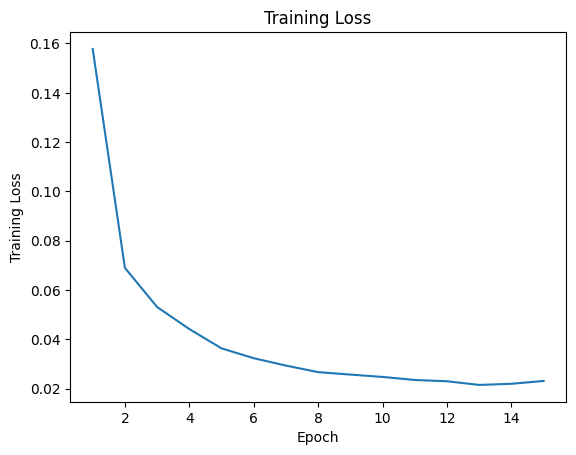

In [ ]:
# plotting the training loss graph

plt.plot(range(1, len(train_losses) + 1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss')
plt.show()

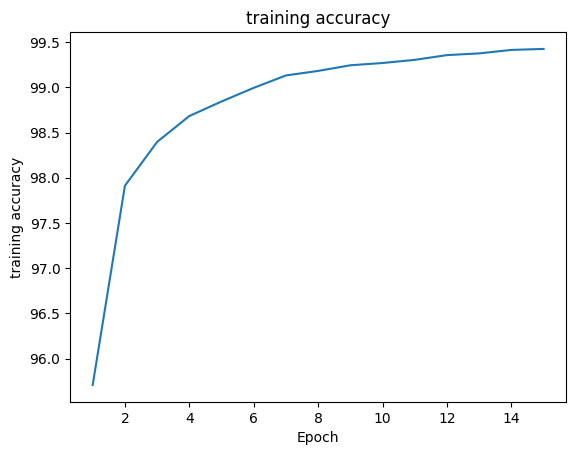

In [ ]:
#printing the training accuracy curve
plt.plot(range(1,len(train_accuracies) + 1), train_accuracies)
plt.xlabel('Epoch')
plt.ylabel('training accuracy')
plt.title('training accuracy')
plt.show()

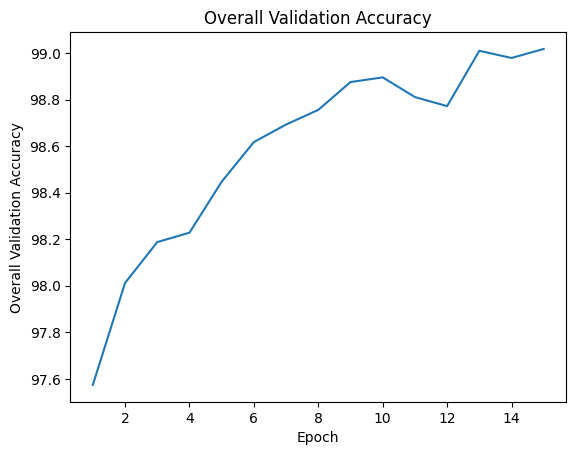

In [ ]:
#printing the validation accuracy graph

plt.plot(range(1, len(val_alphabet_accuracies) + 1), val_overall_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Overall Validation Accuracy')
plt.title('Overall Validation Accuracy')
plt.show()

In [ ]:
# printing models final accuracy

final_val_accuracy = val_overall_accuracies[-1]
print(f"Final Validation Accuracy: {final_val_accuracy:.2f}%")

Final Validation Accuracy: 99.02%


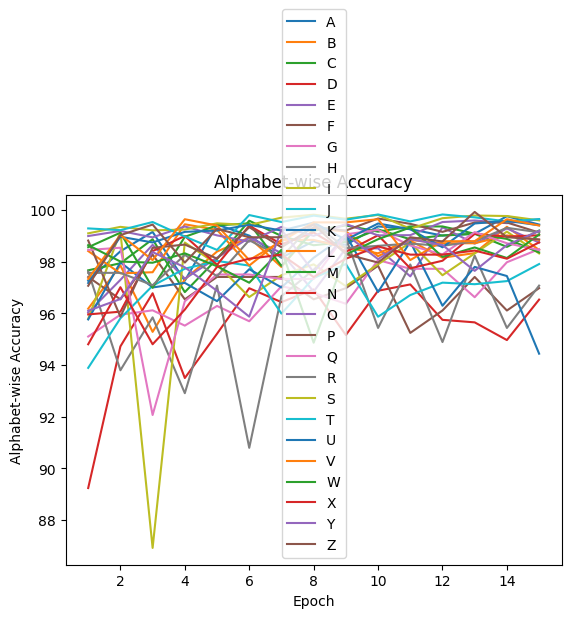

In [ ]:
# Plot the alphabet-wise accuracy graph
alphabet_labels = [chr(ord('A') + i) for i in range(26)]
for i in range(26):
    plt.plot(range(1, len(val_alphabet_accuracies) + 1), [acc[i] for acc in val_alphabet_accuracies], label=alphabet_labels[i])
plt.xlabel('Epoch')
plt.ylabel('Alphabet-wise Accuracy')
plt.title('Alphabet-wise Accuracy')
plt.legend()
plt.show()

In [ ]:
# printing alphabetwise accuracy

final_alphabet_accuracies = val_alphabet_accuracies[-1]
for i in range(26):
    print(f"Accuracy for alphabet '{alphabet_labels[i]}': {final_alphabet_accuracies[i]:.2f}%")

Accuracy for alphabet 'A': 99.43%
Accuracy for alphabet 'B': 98.45%
Accuracy for alphabet 'C': 99.20%
Accuracy for alphabet 'D': 96.53%
Accuracy for alphabet 'E': 98.74%
Accuracy for alphabet 'F': 96.97%
Accuracy for alphabet 'G': 98.48%
Accuracy for alphabet 'H': 97.07%
Accuracy for alphabet 'I': 98.31%
Accuracy for alphabet 'J': 97.90%
Accuracy for alphabet 'K': 94.43%
Accuracy for alphabet 'L': 98.84%
Accuracy for alphabet 'M': 98.35%
Accuracy for alphabet 'N': 99.01%
Accuracy for alphabet 'O': 99.64%
Accuracy for alphabet 'P': 99.12%
Accuracy for alphabet 'Q': 98.45%
Accuracy for alphabet 'R': 99.13%
Accuracy for alphabet 'S': 99.59%
Accuracy for alphabet 'T': 99.64%
Accuracy for alphabet 'U': 99.40%
Accuracy for alphabet 'V': 99.39%
Accuracy for alphabet 'W': 99.04%
Accuracy for alphabet 'X': 98.74%
Accuracy for alphabet 'Y': 99.18%
Accuracy for alphabet 'Z': 98.86%
